# An Intrusion Detection System with Response Component for Industrial IoT


## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [3]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

## Read the CICIDS2017 dataset
CICIDS2017 dataset contains benign and the most up-to-date common attacks, which resembles the true real-world data (PCAPs). It also includes the results of the network traffic analysis using CICFlowMeter with labeled flows based on the time stamp, source, and destination IPs, source and destination ports, protocols and attack (CSV files). Also available is the extracted features definition. 

## Read the CIC-ToN-IoT 2021 dataset
A dataset generated where the feature set of the CICFlowMeter was extracted from the pcap files of the ToN-IoT dataset. The CICFlowMeter-v4 tool was utilised to extract 83 features. There are 5,351,760 data samples where 2,836,524 (53.00%) are attacks and 2,515,236 (47.00%) are benign samples.

In [5]:
#Read dataset
df = pd.read_csv("/Users/madhurpatle/Downloads/Project/MTech/IRS/data/CICIDS2017_sample.csv")
dff = pd.read_csv("/Users/madhurpatle/Downloads/Project/MTech/IRS/data/CIC-ToN-IoT.csv")


In [7]:
dff

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Attack
0,177.30.87.144-192.168.1.1-0-0-0,177.30.87.144,0,192.168.1.1,0,0,25/04/2019 05:18:52 pm,47814343,5,0,...,1038036.0,0.000000e+00,1038036.0,1038036.0,5.187256e+14,8.984590e+14,1.556177e+15,1.657324e+07,0,Benign
1,167.49.176.28-50.165.192.168-0-0-0,167.49.176.28,0,50.165.192.168,0,0,25/04/2019 05:18:49 pm,2033142,2,0,...,0.0,0.000000e+00,0.0,0.0,1.556177e+15,0.000000e+00,1.556177e+15,1.556177e+15,0,Benign
2,230.158.52.59-177.21.192.168-0-0-0,230.158.52.59,0,177.21.192.168,0,0,25/04/2019 05:18:37 pm,82877133,14,0,...,1931160.5,1.711593e+06,3942470.0,226402.0,1.729085e+14,5.187256e+14,1.556177e+15,6.036493e+06,0,Benign
3,183.68.192.168-1.1.192.168-0-0-0,183.68.192.168,0,1.1.192.168,0,0,25/04/2019 05:18:42 pm,24359,2,0,...,0.0,0.000000e+00,0.0,0.0,1.556177e+15,0.000000e+00,1.556177e+15,1.556177e+15,0,Benign
4,183.41.192.168-1.1.192.168-0-0-0,183.41.192.168,0,1.1.192.168,0,0,25/04/2019 05:18:42 pm,10239351,3,0,...,4053975.0,0.000000e+00,4053975.0,4053975.0,7.780884e+14,1.100383e+15,1.556177e+15,6.185376e+06,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5351755,96.49.192.168-1.30.18.184-0-0-0,96.49.192.168,0,1.30.18.184,0,0,25/04/2019 04:34:34 pm,43774681,2,0,...,0.0,0.000000e+00,0.0,0.0,7.780871e+14,1.100381e+15,1.556174e+15,4.377468e+07,0,Benign
5351756,57.157.192.168-1.30.192.168-0-0-0,57.157.192.168,0,1.30.192.168,0,0,25/04/2019 04:30:56 pm,29833504,2,0,...,0.0,0.000000e+00,0.0,0.0,7.780869e+14,1.100381e+15,1.556174e+15,2.983350e+07,0,Benign
5351757,183.43.192.168-1.1.192.168-0-0-0,183.43.192.168,0,1.1.192.168,0,0,25/04/2019 04:48:39 pm,28680917,2,0,...,0.0,0.000000e+00,0.0,0.0,7.780875e+14,1.100382e+15,1.556175e+15,2.868092e+07,0,Benign
5351758,193.129.192.168-1.195.192.168-0-0-0,193.129.192.168,0,1.195.192.168,0,0,25/04/2019 05:01:42 pm,7210916,2,0,...,0.0,0.000000e+00,0.0,0.0,7.780879e+14,1.100382e+15,1.556176e+15,7.210916e+06,0,Benign


In [6]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [8]:
df.Label.value_counts()

BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: Label, dtype: int64

In [9]:
dff.Label.value_counts()

1    2836524
0    2515236
Name: Label, dtype: int64

### Data sampling

In [10]:
# Randomly sample instances from majority classes
df_minor = df[(df['Label']=='WebAttack')|(df['Label']=='Bot')|(df['Label']=='Infiltration')]
df_BENIGN = df[(df['Label']=='BENIGN')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.01, replace=False, weights=None, random_state=None, axis=0)
df_DoS = df[(df['Label']=='DoS')]
df_DoS = df_DoS.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_PortScan = df[(df['Label']=='PortScan')]
df_PortScan = df_PortScan.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_BruteForce = df[(df['Label']=='BruteForce')]
df_BruteForce = df_BruteForce.sample(n=None, frac=0.2, replace=False, weights=None, random_state=None, axis=0)

In [11]:
df_s = df_BENIGN.append(df_DoS).append(df_PortScan).append(df_BruteForce).append(df_minor)

In [12]:
df_s = df_s.sort_index()

In [13]:
# Save the sampled dataset
df_s.to_csv("/Users/madhurpatle/Downloads/Project/MTech/IRS/data/CICIDS2017_2.csv",index=0)

### Preprocessing (normalization and padding values)

In [14]:
df = pd.read_csv("/Users/madhurpatle/Downloads/Project/MTech/IRS/data/CICIDS2017_2.csv")

In [15]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [16]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [17]:
X_train.shape

(5048, 77)

In [18]:
pd.Series(y_train).value_counts()

6    1744
1    1573
3     761
2     442
5     317
0     182
4      29
dtype: int64

### Oversampling by SMOTE

In [19]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"

In [21]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [22]:
pd.Series(y_train).value_counts()

6    1744
1    1573
4    1500
3     761
2     442
5     317
0     182
dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.9833729216152018
Precision of DT: 0.9830992431431013
Recall of DT: 0.9833729216152018
F1-score of DT: 0.9830734902376914
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        45
           1       0.99      0.99      0.99       393
           2       0.97      0.98      0.98       111
           3       0.99      0.98      0.99       191
           4       1.00      0.71      0.83         7
           5       1.00      0.99      0.99        80
           6       0.99      1.00      0.99       436

    accuracy                           0.98      1263
   macro avg       0.96      0.92      0.94      1263
weighted avg       0.98      0.98      0.98      1263



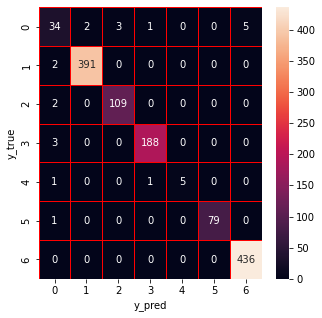

In [23]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [24]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9873317498020586
Precision of RF: 0.987157838790107
Recall of RF: 0.9873317498020586
F1-score of RF: 0.987193155354275
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        45
           1       1.00      0.99      1.00       393
           2       0.99      0.98      0.99       111
           3       1.00      0.99      0.99       191
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00        80
           6       0.98      1.00      0.99       436

    accuracy                           0.99      1263
   macro avg       0.95      0.93      0.94      1263
weighted avg       0.99      0.99      0.99      1263



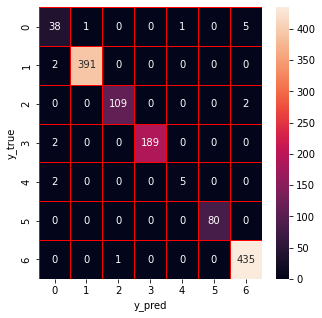

In [25]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [26]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9865399841646872
Precision of ET: 0.9870386537980785
Recall of ET: 0.9865399841646872
F1-score of ET: 0.9865922295550109
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        45
           1       1.00      0.99      1.00       393
           2       0.95      0.98      0.96       111
           3       1.00      0.99      1.00       191
           4       1.00      0.71      0.83         7
           5       1.00      0.99      0.99        80
           6       0.99      0.99      0.99       436

    accuracy                           0.99      1263
   macro avg       0.97      0.94      0.95      1263
weighted avg       0.99      0.99      0.99      1263



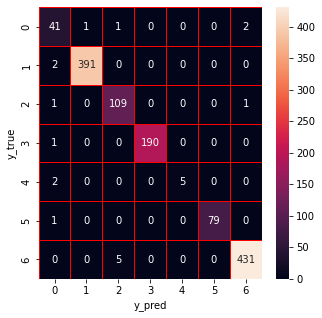

In [27]:
# Extra trees training and prediction
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [28]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

[18:37:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9897070467141726
Precision of XGBoost: 0.9896880805741003
Recall of XGBoost: 0.9897070467141726
F1-score of XGBoost: 0.98954743841639
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        45
           1       1.00      0.99      1.00       393
           2       0.98      0.98      0.98       111
           3       0.99      1.00      0.99       191
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99        80
           6       1.00      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.98      0.94    

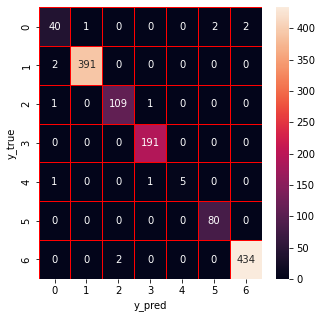

In [29]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [30]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)

In [31]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,1,1,1,1
1,6,6,6,6
2,3,3,3,6
3,6,6,6,6
4,2,2,2,2


In [32]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [33]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [34]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

[18:37:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy of Stacking: 0.9833729216152018
Precision of Stacking: 0.9831559971415149
Recall of Stacking: 0.9833729216152018
F1-score of Stacking: 0.9830757322517572
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        45
           1       0.98      0.99      0.99       393
           2       1.00      0.98      0.99       111
           3       1.00      0.98      0.99       191
           4       1.00      0.71      0.83         7
           5       1.00      0.99      0.99        80
           6       0.99      1.00      0.99       436

    accuracy                           0.98      1263
   macro avg       0.97      0.92      0.94      1263
weighted avg       0.98      0.98      0.98      1263



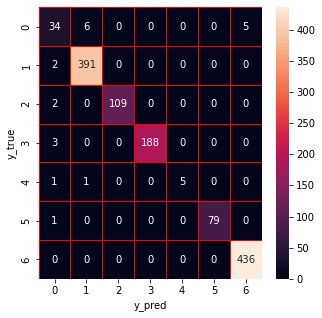

In [35]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Feature Selection

### Feature importance

In [36]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [37]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [38]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.1086, 'Init_Win_bytes_backward'), (0.0855, 'min_seg_size_forward'), (0.0773, 'Total Length of Fwd Packets'), (0.0602, 'Flow IAT Max'), (0.0404, 'Init_Win_bytes_forward'), (0.0404, 'Fwd Packet Length Max'), (0.0366, 'Max Packet Length'), (0.0242, 'Bwd Packets/s'), (0.0229, 'Bwd Packet Length Std'), (0.0226, 'Bwd Packet Length Min'), (0.0225, 'Flow IAT Std'), (0.0222, 'Average Packet Size'), (0.0219, 'Avg Bwd Segment Size'), (0.0175, 'Flow Duration'), (0.0169, 'Packet Length Mean'), (0.0167, 'Total Backward Packets'), (0.0159, 'Fwd IAT Mean'), (0.0145, 'PSH Flag Count'), (0.0142, 'Fwd Packet Length Std'), (0.014, 'Bwd Packet Length Mean'), (0.0134, 'Fwd Header Length'), (0.0127, 'Fwd IAT Max'), (0.0126, 'Fwd IAT Total'), (0.0123, 'Total Length of Bwd Packets'), (0.0116, 'Bwd Packet Length Max'), (0.0102, 'URG Flag Count'), (0.0101, 'Active Max'), (0.01, 'Flow IAT Mean'), (0.0098, 'ACK Flag Count'), (0.0097, 'Subflow Fwd Packets'), (0.0096, 'Fwd Packet 

In [39]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [40]:
len(f_list)

77

In [41]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [42]:
X_fs = df[fs].values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [44]:
X_train.shape

(5048, 41)

In [45]:
pd.Series(y_train).value_counts()

6    1744
1    1573
3     761
2     442
5     317
0     182
4      29
dtype: int64

### Oversampling by SMOTE

In [46]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500})

In [49]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [50]:
pd.Series(y_train).value_counts()

6    1744
1    1573
4    1500
3     761
2     442
5     317
0     182
dtype: int64

## Machine learning model training after feature selection

Accuracy of DT: 0.9881235154394299
Precision of DT: 0.9881307821603736
Recall of DT: 0.9881235154394299
F1-score of DT: 0.9879718951807593
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        45
           1       1.00      0.99      1.00       393
           2       0.98      0.98      0.98       111
           3       0.97      0.99      0.98       191
           4       1.00      0.71      0.83         7
           5       1.00      0.99      0.99        80
           6       1.00      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.98      0.93      0.95      1263
weighted avg       0.99      0.99      0.99      1263



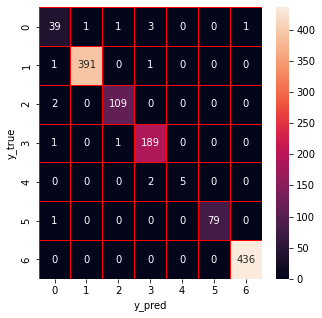

In [51]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [52]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9897070467141726
Precision of RF: 0.9901628998729841
Recall of RF: 0.9897070467141726
F1-score of RF: 0.9897401338030803
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        45
           1       1.00      0.99      1.00       393
           2       0.98      0.98      0.98       111
           3       1.00      0.99      0.99       191
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00        80
           6       0.99      1.00      0.99       436

    accuracy                           0.99      1263
   macro avg       0.98      0.94      0.96      1263
weighted avg       0.99      0.99      0.99      1263



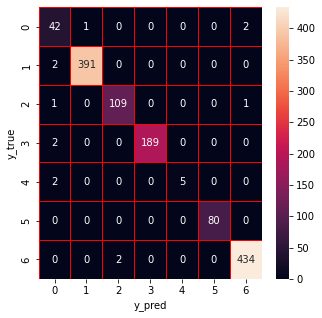

In [53]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [54]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9897070467141726
Precision of ET: 0.9900622704748446
Recall of ET: 0.9897070467141726
F1-score of ET: 0.9897141421450035
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        45
           1       1.00      0.99      1.00       393
           2       0.98      0.98      0.98       111
           3       1.00      0.99      1.00       191
           4       1.00      0.71      0.83         7
           5       1.00      0.99      0.99        80
           6       0.99      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.98      0.94      0.95      1263
weighted avg       0.99      0.99      0.99      1263



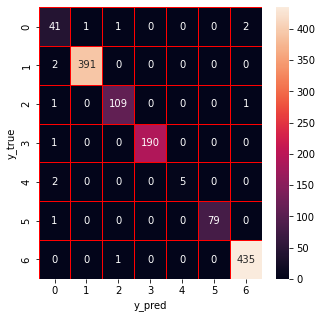

In [55]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [56]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

[18:37:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost: 0.9889152810768013
Precision of XGBoost: 0.9888415797923366
Recall of XGBoost: 0.9889152810768013
F1-score of XGBoost: 0.9886573115604409
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        45
           1       0.99      0.99      0.99       393
           2       0.98      0.98      0.98       111
           3       0.98      1.00      0.99       191
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99        80
           6       0.99      1.00      0.99       436

    accuracy                           0.99      1263
   macro avg       0.98      0.94  

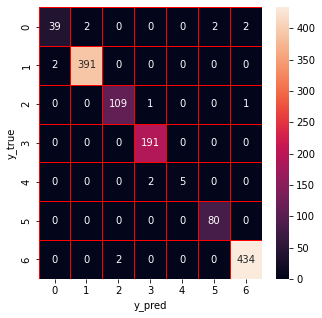

In [57]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [58]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [59]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,1,1,1,1
1,6,6,6,6
2,3,3,3,6
3,6,6,6,6
4,2,2,2,2


In [60]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [61]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

[18:37:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of Stacking: 0.9897070467141726
Precision of Stacking: 0.9896670201633435
Recall of Stacking: 0.9897070467141726
F1-score of Stacking: 0.9895320499426251
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        45
           1       0.99      1.00      0.99       393
           2       1.00      0.98      0.99       111
           3       0.99      0.99      0.99       191
           4       1.00      0.71      0.83         7
           5       1.00      0.99      0.99        80
           6       1.00      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.98      0.

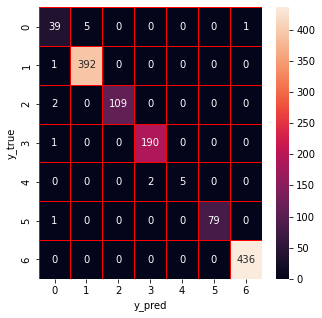

In [62]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()